# Data Pre-processing

Data exploration and analysis for the purpose of pre-processing, null imputation and feature engineering. This workbook's purpose is to output seperate datasets a train/test and validation datasets: <br>
1. For modelling (notebook 04) with imputed nulls and encoded features; <br>
2. Seperate dataset for insight oriented analysis (notebook 03).<br>

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from visualisations import compare_histograms
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import json

sns.set_theme(context='notebook', style='darkgrid', palette='Set3')

In [2]:
df = pd.read_csv('../data/clean_combined_wines.csv')
df.set_index('name', inplace=True)
df.head()

,region,country,vintage,producer,wine_variety,grape_variety,price,rating,rating_qty,abv,reviewed_by,from_vivino
name,,,,,,,,,,,,
00 Wines Vgw Chardonnay 2017,Willamette Valley,United States,2017,00 Wines,white,Chardonnay,79.99,0.0,0,13.0,"JS, WE, WS",False
00 Wines Vgr Pinot Noir 2019,Willamette Valley,United States,2019,00 Wines,red,Pinot Noir,99.99,0.0,0,12.9,"WE, JS, RP",False
00 Wines Egw Chardonnay 2019,Willamette Valley,United States,2019,00 Wines,white,Chardonnay,115.99,0.0,0,NaN,"JS, RP, WE",False
100 Nails Ranch Pinot Noir 2019,Central Coast,United States,2019,100 Nails Ranch,red,Pinot Noir,16.99,0.0,0,14.2,WW,False
100 Nails Ranch Chardonnay 2019,Sonoma County,United States,2019,100 Nails Ranch,white,Chardonnay,16.99,0.0,0,14.2,0,False


In [3]:
# Add a column for age
df['age'] = df['vintage'].apply(lambda x: 2024 - int(x))

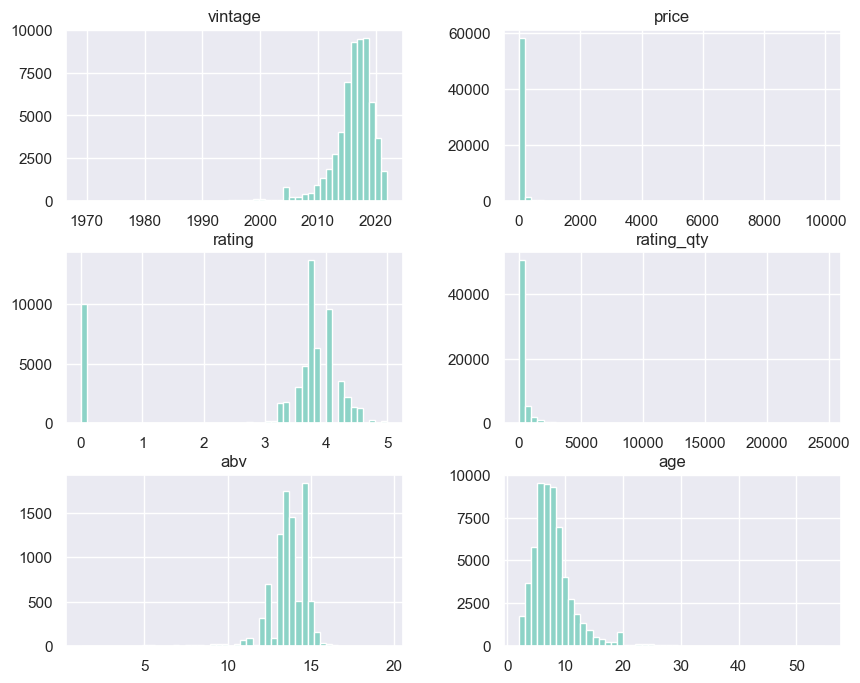

In [4]:
# Plot distributions
df.hist(bins=50, figsize=(10, 8));

* Vintage skewed left centred around a median 2016. Age the reverse, median age of 8 years (as of 2024). 
* Price and rating quantity both could benefit from logarithmic transformation for the benefit of modelling. 
* Rating quantity, likely many zero values, a minimum limit will be set for rating_qty so that ratings can be considered reliable. 
* Rating median 3.8 and mean 3.11, mean likely being skewed due to those wines with 0 ratings having a rating of 0 currently in the dataset.
[Futher analysis of distributions, post-transformation can be seen in the following notebook]

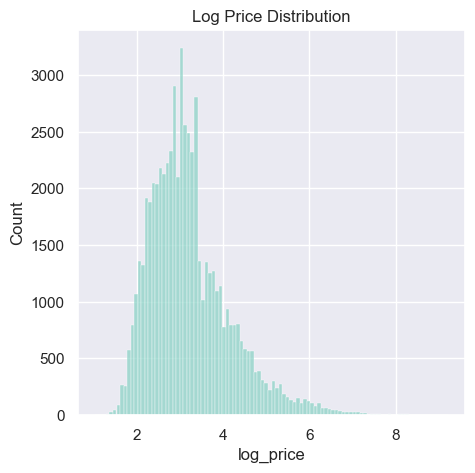

In [5]:
# log transform price and plot
df['log_price'] = np.log(df['price'])
plt.figure(figsize=(5, 5))
plt.title('Log Price Distribution')
sns.histplot(df['log_price'], bins=100);

* Log price much more normally distributed. 

In [6]:
df['log_price'].describe()

count    60265.000000
mean         3.215339
std          0.940724
min          1.029619
25%          2.564180
50%          3.044522
75%          3.685624
max          9.210339
Name: log_price, dtype: float64

/Users/AaranDaniel/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


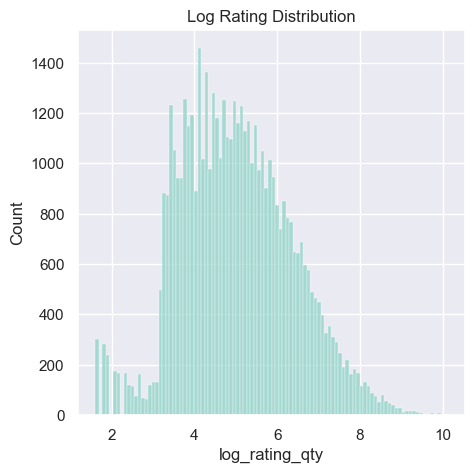

In [7]:
# log rating quantity
df['log_rating_qty'] = np.log(df['rating_qty'])
plt.figure(figsize=(5, 5))
plt.title('Log Rating Distribution')
sns.histplot(df['log_rating_qty'], bins=100);

* More normally distributed which will be better suited to a linear regression model and perhaps to feature engineering. 
* One of the data scrapes in our original data set had a cut off for minimum number of reviews. Hence the sharp drop in log rating_qty at around 3.5. We will consider limiting modelled data to only those with a minimum number of reviews for reliability of reviews.  

In [8]:
# There are 8980 wines with 0 ratings, 10836 wines with less than 20. 
# Drop all with less than 20. 
df = df[df['rating_qty'] >20]

### Reduce Categories 

In [9]:
# Reduce the number of regions in df
print('Prior Length:', df['region'].value_counts().shape[0])
region_value_counts = df['region'].value_counts()
remove_regions = region_value_counts[region_value_counts < 31]
df['region'] = df['region'].apply(lambda x: 'Other' if x in remove_regions.index else x)
print('Post Length:', df['region'].value_counts().shape[0])

Prior Length: 1024
Post Length: 258


In [10]:
# Reduce the number of countries in df
print('Prior Length:', df['country'].value_counts().shape[0])
country_value_counts = df['country'].value_counts()
remove_country = country_value_counts[country_value_counts < 31]
df['country'] = df['country'].apply(lambda x: 'Other' if x in remove_country.index else x)
print('Post Length:', df['country'].value_counts().shape[0])

Prior Length: 38
Post Length: 24


### Label Encoding

In [11]:
print(f'ABV nulls: {(df["abv"].isna().sum())}')

ABV nulls: 47197


In [12]:
df_encoded = df.copy()
columns_to_encode = ['region', 'country', 'vintage', 'wine_variety', 'grape_variety', 'from_vivino', 'producer']

le_dict = {}

# Fit and transform the training dataset and transform the validation dataset
for column in columns_to_encode:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column].astype(str))
    le_dict[column] = le
    

In [13]:
# Save mappings for use later in application. 
category_mappings = {}
# Iterate over the label encoder dictionary to extract and category mappings
for column, le in le_dict.items():
    mappings = {class_label: int(encoded_label) for class_label, encoded_label in zip(le.classes_, le.transform(le.classes_))}
    category_mappings[column.capitalize()] = mappings
# Export mapping dictionary as json
with open('../mapping/label_mapping.json', 'w') as file:
    json.dump(category_mappings, file)

### Null Imputation

In [14]:
# Impute missing abv values on train/test df 
it_imp = IterativeImputer(estimator=LinearRegression(), 
                           max_iter=5)
imputed_data = it_imp.fit_transform(df_encoded.drop(columns = ['reviewed_by']))
imputed_data = pd.DataFrame(imputed_data, columns=df.drop(columns = ['reviewed_by']).columns)

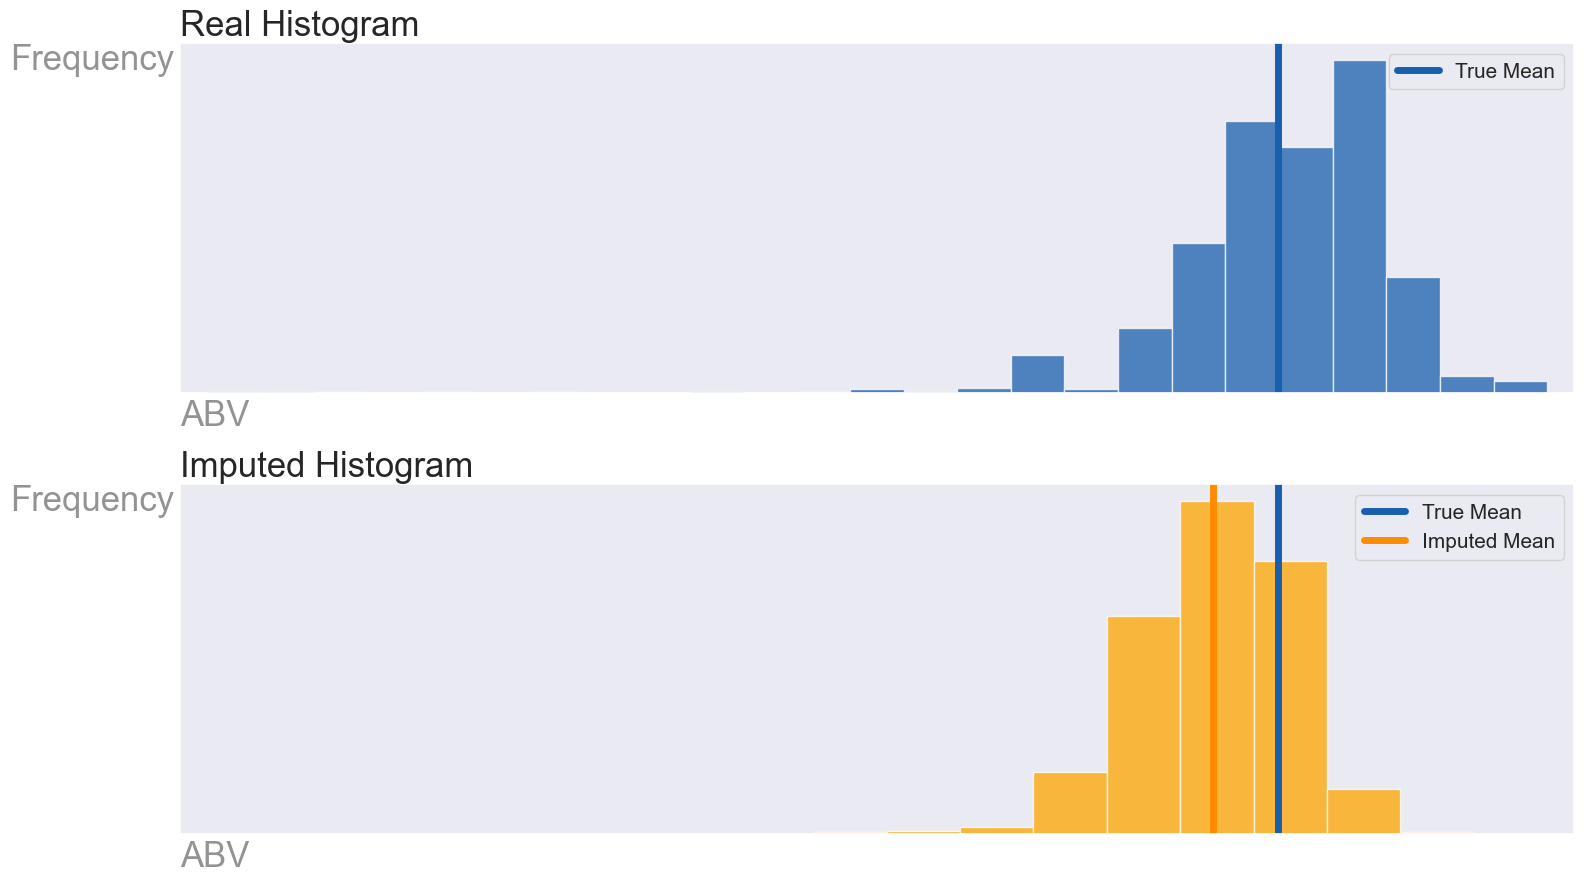

In [15]:
compare_histograms(imputed_column = imputed_data['abv'],
                   original_column = df['abv'],
                   x_label = 'ABV',
                   y_label = 'Frequency', bins = 25)

In [16]:
# Try with decision tree classifier 
it_imp_rf = IterativeImputer(estimator=DecisionTreeRegressor(random_state=42), 
                           max_iter=5)
imputed_data_rf = it_imp_rf.fit_transform(df_encoded.drop(columns = ['reviewed_by']))
imputed_data_rf = pd.DataFrame(imputed_data_rf, columns=df_encoded.drop(columns = ['reviewed_by']).columns)

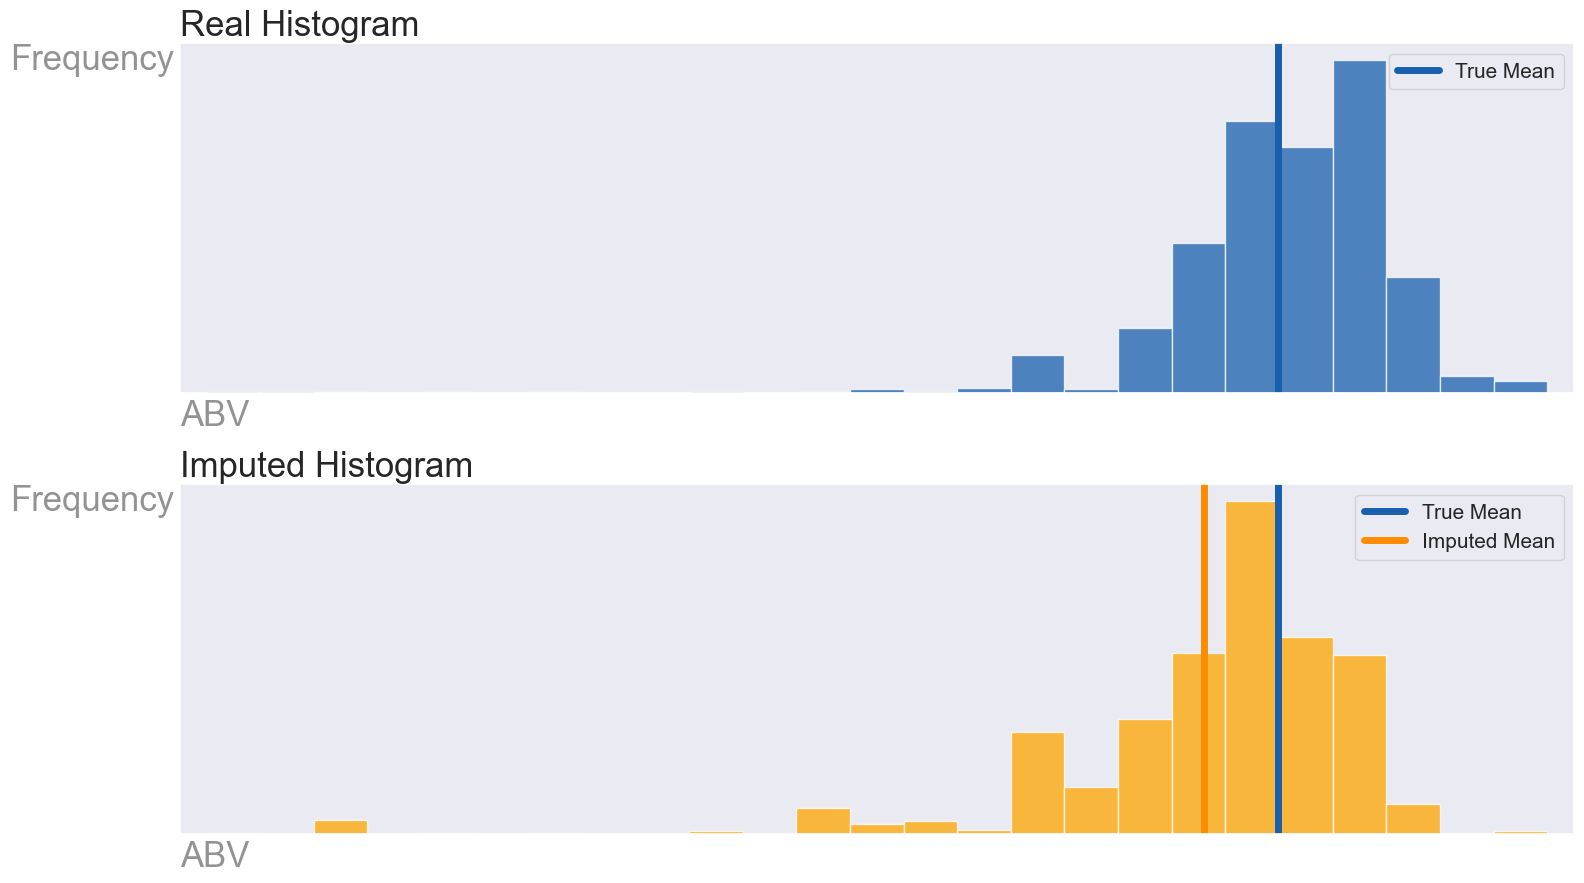

In [17]:
compare_histograms(imputed_column = imputed_data_rf['abv'],
                   original_column = df['abv'],
                   x_label = 'ABV',
                   y_label = 'Frequency', bins = 25)

The linear regression imputation is better at maintaining the mean of the distrbution and although it reduces the spread of the ABV distribution it matches the over all shape with less outliers than decision trees. 

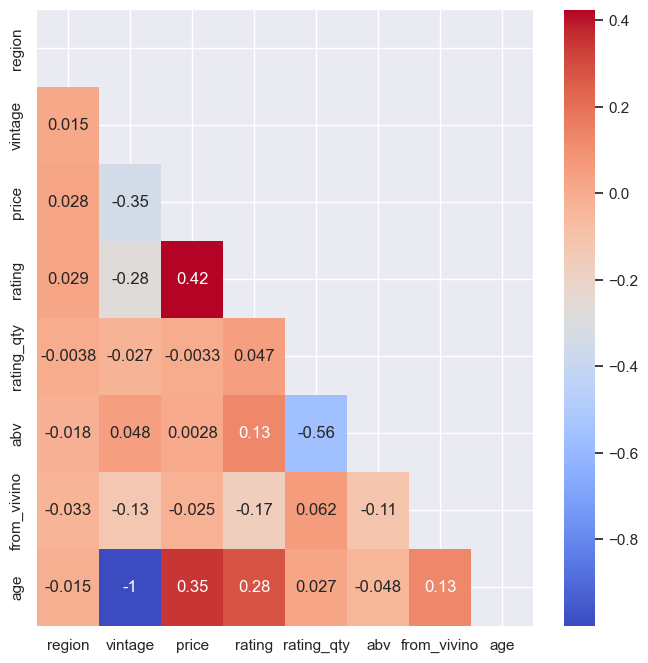

In [18]:
# Check correlation in data with label encoded features
numeric = imputed_data.drop(columns = ['country', 'wine_variety', 'grape_variety', 'producer', 'log_price', 'log_rating_qty'])

plt.figure(figsize=(8, 8))
mask = np.zeros_like(numeric.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(numeric.corr(), mask = mask, annot=True, cmap='coolwarm');

* As should be expected the encoded categorical variables have little to no correlation with price, rating and other continuous variables. 

### Additional Feature Engineering

In [19]:
imputed_data['age^2'] = imputed_data['age'] ** 2
imputed_data['rating * log_rating_qty'] = imputed_data['rating'] * imputed_data['log_rating_qty']
# Put name index on inputed set 
imputed_data.index = df.index

### Splitting Data into Train/Test and seperated Validation set

In [20]:
df_train_test_imputed, df_validation_imputed = train_test_split(imputed_data, test_size=0.1, random_state=42)
print(df_train_test_imputed.shape)
print(df_validation_imputed.shape)

(43328, 16)
(4815, 16)


In [21]:
df_tt_eda, df_val_eda = train_test_split(df, test_size=0.1, random_state=42)
print(df_tt_eda.shape)
print(df_val_eda.shape)

(43328, 15)
(4815, 15)


In [22]:
# Export pre-processed Train and Test datasets.
# EDA (workbook 03):
df_tt_eda.to_csv('../data/clean_test_train.csv', index=True)

# Modelling (workbook 04):
df_train_test_imputed.to_csv('../data/modelling_wines.csv', index=True)


# Export validation datasets for use in validation and app.
df_val_eda.to_csv('../data/validation_frontend.csv', index=True)

# For modelling (workbook 05):
df_validation_imputed.to_csv('../data/validation_modelling.csv', index=True)